In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read
df = pd.read_csv('data/5guys_flight_data_preprocessed.csv')
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_DEL15,CRS_ELAPSED_TIME,CARRIER_NAME,...,PREVIOUS_AIRPORT,AWND,PRCP,TAVG,WDF2,WSF2,WT03,WT08,DEL_ORIGIN_COUNT,WT_FOG
0,0,27,0,182,14,12,1028,1.0,1.690223,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1
1,0,27,0,2365,14,3,1011,1.0,0.255376,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1
2,0,27,0,1481,14,6,600,1.0,0.308031,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1
3,0,27,0,2401,14,3,851,0.0,0.255376,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1
4,0,27,0,2941,14,12,754,1.0,1.729714,15,...,53,1.214051,1.235494,-2.485781,1.0097,1.085395,-0.376401,2.327994,2.196709,1


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/terlan/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'C': 0.001, 'penalty': 'l2'}


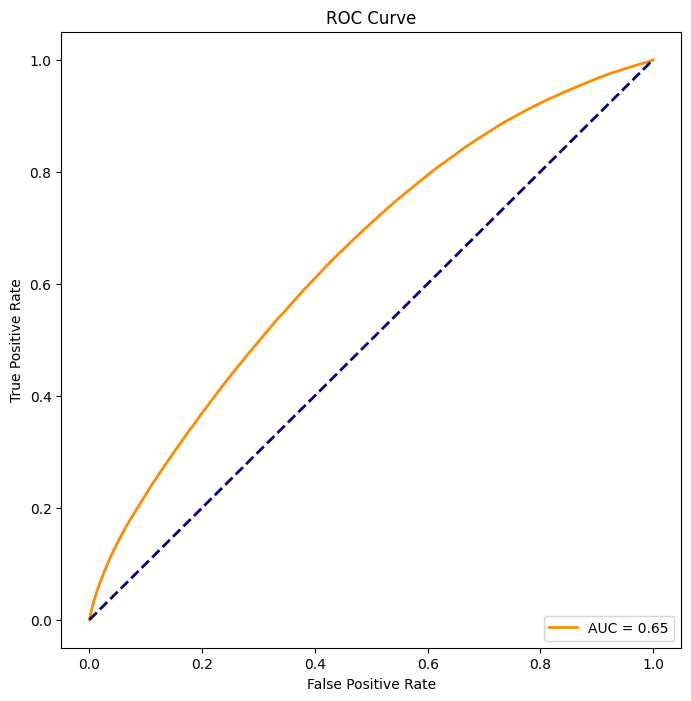

Accuracy: 0.6021007873348747
Confusion Matrix:
[[528857 351964]
 [ 80182 125066]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.60      0.71    880821
         1.0       0.26      0.61      0.37    205248

    accuracy                           0.60   1086069
   macro avg       0.57      0.60      0.54   1086069
weighted avg       0.75      0.60      0.65   1086069



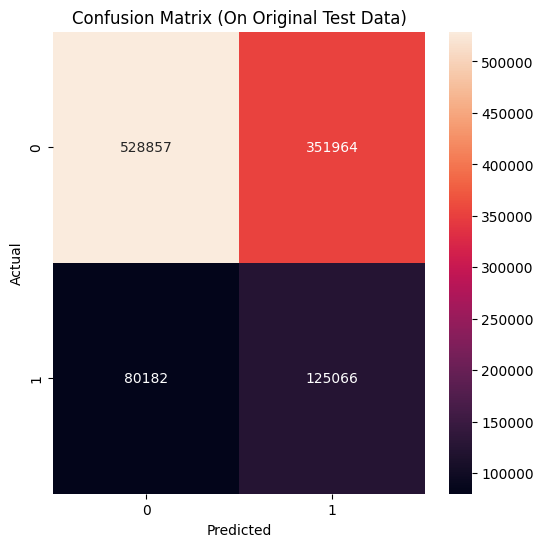

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Select all columns as features except the target column
features = df.columns.tolist()
features.remove('DEP_DEL15')

target = 'DEP_DEL15'  # You can choose another relevant column for binary classification
df = df.dropna(subset=[target])

# Split the dataset into training and testing sets
X = df[features]
y = df[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform RandomUnderSampler undersampling on the training data only
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Create and train a Logistic Regression model on the resampled training data
model = LogisticRegression(random_state=42, solver='liblinear')

parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring='f1',
    n_jobs=5,
    cv=5,
    verbose=True
)

grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters are {'C': 0.1, 'penalty': 'l2'}
print(grid_search.best_params_)

# Make predictions on the original test set
y_pred = grid_search.predict(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the original test set
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

# Confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, cmap='rocket', fmt='g', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (On Original Test Data)')
plt.show()
